In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
import pysal as ps
import pylab as pl
from shapely.geometry import Point
import seaborn as sns
import shapefile
import mplleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [82]:
df = pd.read_csv('JoinACSFCCPluto.csv')

In [3]:
# myshapefile = 'JOINACSPLUTOFCC/JOINACSPLUTOFCC.shp'
# gdf = gp.read_file(myshapefile)

In [16]:
all_filenames = {}
all_filenames['bk'] = 'shape_by_boro/BK.shp'
all_filenames['bx'] = 'shape_by_boro/BX.shp'
all_filenames['mn'] = 'shape_by_boro/MN.shp'
all_filenames['qn'] = 'shape_by_boro/QN.shp'
all_filenames['si'] = 'shape_by_boro/SI.shp'

master = {}

master['bk'] = gp.read_file(bk_filename)
master['bx'] = gp.read_file(bx_filename)
master['mn'] = gp.read_file(mn_filename)
master['qn'] = gp.read_file(qn_filename)
master['si'] = gp.read_file(si_filename)

In [9]:
# shapes['FIPS'] = shapes.GEOID.astype(int64)

# set pysal weights

In [17]:
# set geoms
all_geoms = {}

# psGeom = ps.open('shape_by_boro/All_Tracts.shp','r')

for k,v in all_filenames.items():
    all_geoms[k] = ps.open(v,'r')

In [19]:
# find weight

all_weights = {}

for k,v in all_geoms.items():
    w = ps.buildContiguity(v, criterion='queen')
    w.transorm = 'R'
    all_weights[k] = w


# w = ps.buildContiguity(psGeom,criterion='queen')
# w.transform = 'R'

Island id:  [131]


In [40]:
# Save this for column reference
#### Bscore_norm is JoinedD_11
#### FIPS is JoinedDa_1

In [168]:
# glocal Moran

all_sa = {}

for k,v in master.items():
    # normalize these!
    Y = v['JoinedD_11'].values
    w = all_weights[k]
    sl = ps.lag_spatial(w, Y)
    v['w_percent'] = sl
    # global
    mi = ps.Moran(Y,w)
    
    # local Moran
    lisa = ps.Moran_Local(Y, w)
    
    # filter for significance
    S = lisa.p_sim < 0.05

    # put into quadrants
    Q = lisa.q
    
    # add new columns back to original dict
    master[k] = v
    
    # tuple of Global I, Expected I, and significance
    all_sa[k] = mi.I, mi.EI, mi.p_sim,S,Q

In [173]:
count = 0
for i in all_sa['bk'][4]:
    if i==2:
        count += 1
print count

12


In [167]:
for k,v in all_sa.items():
    q1 = 0
    q2 = 0
    q3 = 0
    q4 = 0
    for i in v[4]:
        if i== 1:
            q1 += 1
        elif i==2:
            q2 += 1
        elif i==3:
            q3 += 1
        elif i==4:
            q4 += 1
    print "{}:\nGlobal Moran I of {:.4f} at p={:.4f}\
    \n{} census tracts had sig. Local Moran I's. # in each quadrant:\
    \nQ1:{} Q2:{} Q3:{} Q4: {}\n\n".format(k,v[0],v[2],len(v[4]),q1,q2,q3,q4)

si:
Global Moran I of 0.1414 at p=0.0070    
108 census tracts had sig. Local Moran I's. # in each quadrant:    
Q1:44 Q2:17 Q3:35 Q4: 12


mn:
Global Moran I of 0.7021 at p=0.0010    
288 census tracts had sig. Local Moran I's. # in each quadrant:    
Q1:106 Q2:18 Q3:160 Q4: 4


bx:
Global Moran I of 0.4874 at p=0.0010    
337 census tracts had sig. Local Moran I's. # in each quadrant:    
Q1:138 Q2:45 Q3:115 Q4: 39


bk:
Global Moran I of 0.8780 at p=0.0010    
759 census tracts had sig. Local Moran I's. # in each quadrant:    
Q1:499 Q2:12 Q3:229 Q4: 19


qn:
Global Moran I of 0.8259 at p=0.0010    
666 census tracts had sig. Local Moran I's. # in each quadrant:    
Q1:69 Q2:41 Q3:538 Q4: 18




QUADRANTS

Q1 = access high (uniformly high access) (q1,pos) high-high

Q2 = access island inequity (low access surrounded by high access) (q2, neg)

Q3 = access low (uniformly low access) (q3,pos) low-low

Q4 = access island available (high access surrounded by low access) (q4, neg)

In [59]:
# plot -- KEEP

# for k,v in master.items():
#     f, ax = pl.subplots(1, figsize=(10,10))
#     sns.regplot(x='JoinedD_11', y='w_percent', data=v)
#     pl.axvline(0, c='k', alpha=0.5)
#     pl.title(k)
# pl.axhline(0, c='k', alpha=0.5);

In [174]:
# reload into a dataframe
new_dfs = {}

for k,v in all_sa.items():
    records = map(lambda x: (master[k].iloc[x]['JoinedDa_1'], Q[x], master[k].geometry.iloc[x]),
              [i for i,s in enumerate(v[3]) if s])
    new_dfs[k] = gp.GeoDataFrame(records, columns=('FIPS', 'quadrant', 'geometry'))
    new_dfs[k]['FIPS'] = new_dfs[k]['FIPS'].astype(int64)

In [175]:
# merge to old df
final_df = {}

for k,v in new_dfs.items():
    final_df[k] = v.merge(df,how='inner',on='FIPS')
    final_df[k]['boro'] = k

In [176]:
nyc_df_list = []
for k,v in final_df.items():
    nyc_df_list.append(v)

In [177]:
all_nyc = gp.GeoDataFrame(pd.concat(nyc_df_list, ignore_index=True))

In [181]:
all_nyc.to_csv('all_nyc_spatial_auto.csv',index=False)

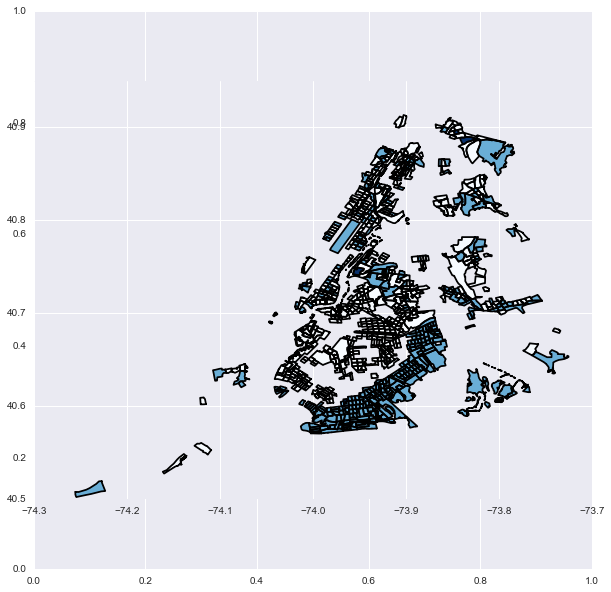

In [180]:
# And plotting it with a basemap
f, ax = plt.subplots(1, figsize=(10,10))
all_nyc.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues');
# mplleaflet.display(fig=f, crs=gdata.crs)